In [11]:
import numpy as np
from data_loader import *

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import figure


import keras
from keras.layers import Input, Reshape, Conv2D, MaxPooling2D, ZeroPadding2D, Flatten, Dropout, Dense, LSTM,Activation
from keras.models import Model, load_model
from keras.utils import plot_model, multi_gpu_model

from scipy import signal

import keras.backend as K

In [3]:
mod_group = 0 
num_files = 2


CLASSES = ['16PSK', '2FSK_5KHz', '2FSK_75KHz', '8PSK', 'AM_DSB', 'AM_SSB', 'APSK16_c34',
 'APSK32_c34', 'BPSK', 'CPFSK_5KHz', 'CPFSK_75KHz', 'FM_NB', 'FM_WB',
 'GFSK_5KHz', 'GFSK_75KHz', 'GMSK', 'MSK', 'NOISE', 'OQPSK', 'PI4QPSK', 'QAM16',
 'QAM32', 'QAM64', 'QPSK']

all_mods = [np.arange(24), np.array([1,9,10,11,12,13]), np.array([4,5]), np.array([1,9]), np.array([6,7,20,21,22])]
mods = all_mods[mod_group]
modulations = [CLASSES[i] for i in mods]
num_classes = mods.size


data = []
for i in range(num_files):
    data_file = "/datax/yzhang/army_challenge/training_data/training_data_chunk_" + str(i) + ".pkl"
    data.append(LoadModRecData(data_file, 1., 0., 0., load_mods=modulations))
    
data_file = "/datax/yzhang/army_challenge/training_data/training_data_chunk_14.pkl"
testdata = LoadModRecData(data_file, 1., 0., 0., load_mods=modulations)

[Data Loader] - Loading Datafile,  /datax/yzhang/army_challenge/training_data/training_data_chunk_0.pkl (time series)
[Data Loader] - Counting Number of Examples in Dataset...
[Data Loader] - Number of Examples in Dataset: 288000
[Data Loader] - [Modulation Dataset] Adding Collects for: 16PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 2FSK_75KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: 8PSK
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_DSB
[Data Loader] - [Modulation Dataset] Adding Collects for: AM_SSB
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK16_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: APSK32_c34
[Data Loader] - [Modulation Dataset] Adding Collects for: BPSK
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_5KHz
[Data Loader] - [Modulation Dataset] Adding Collects for: CPFSK_75KHz
[Data Loader] - [Modulation Dataset]

In [4]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [5]:
number_of_samples_in_instance = data[0].instance_shape[1]
data[0].modTypes

['16PSK',
 '2FSK_5KHz',
 '2FSK_75KHz',
 '8PSK',
 'AM_DSB',
 'AM_SSB',
 'APSK16_c34',
 'APSK32_c34',
 'BPSK',
 'CPFSK_5KHz',
 'CPFSK_75KHz',
 'FM_NB',
 'FM_WB',
 'GFSK_5KHz',
 'GFSK_75KHz',
 'GMSK',
 'MSK',
 'NOISE',
 'OQPSK',
 'PI4QPSK',
 'QAM16',
 'QAM32',
 'QAM64',
 'QPSK']

/home/morads/anaconda3/envs/py36/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


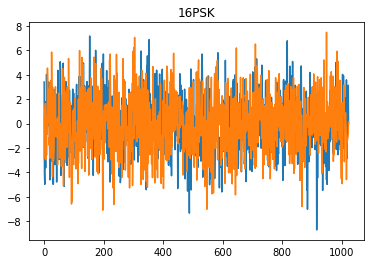

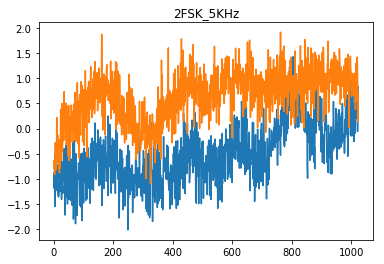

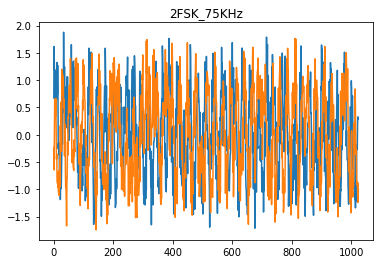

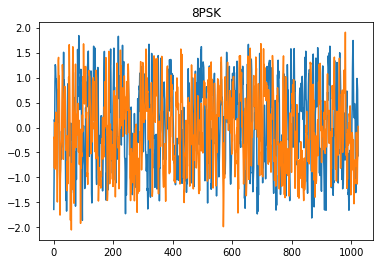

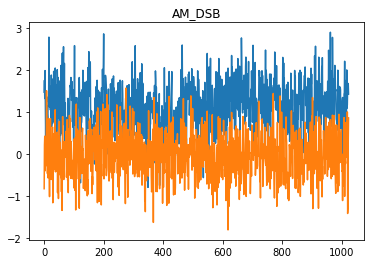

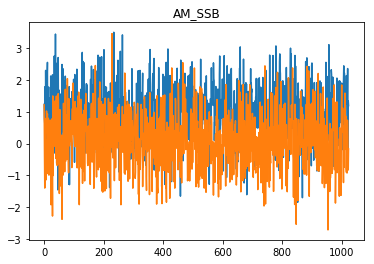

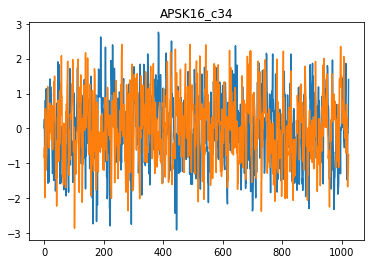

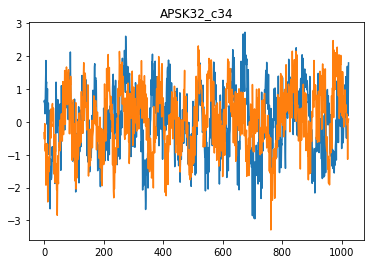

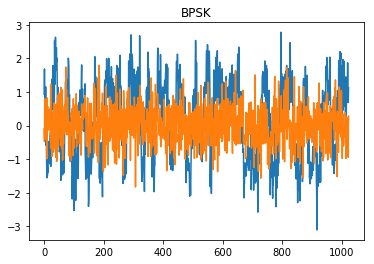

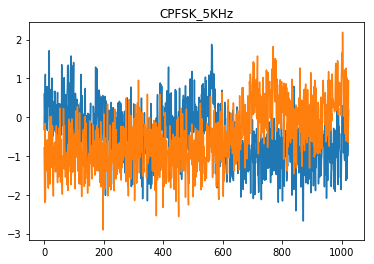

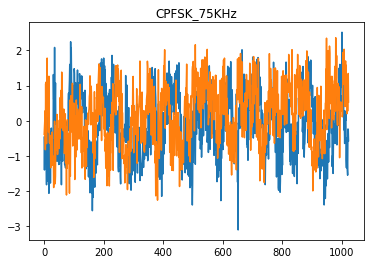

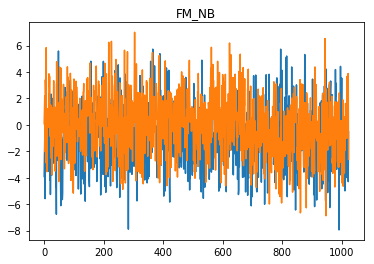

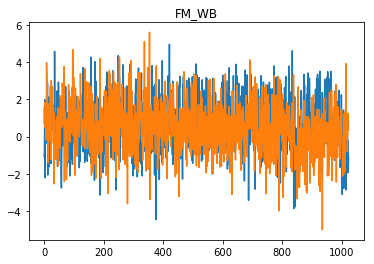

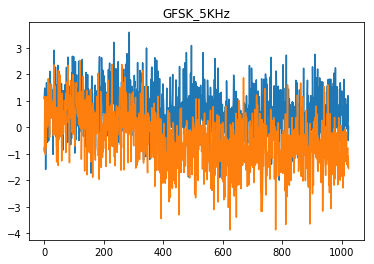

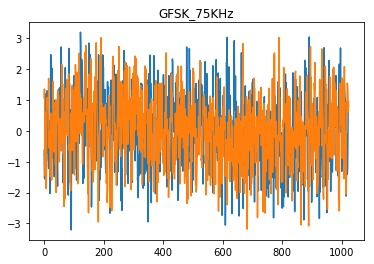

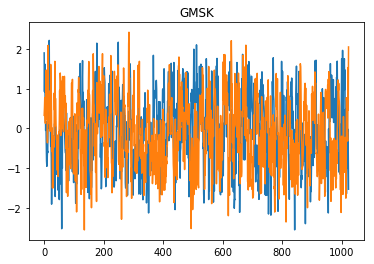

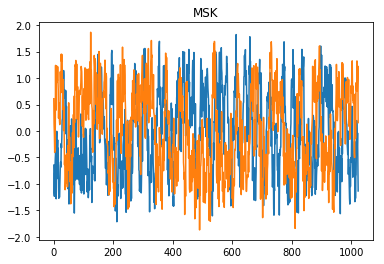

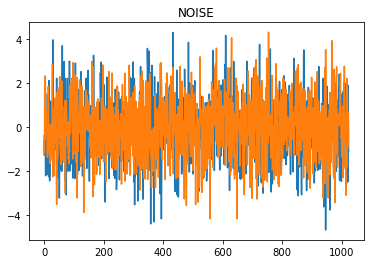

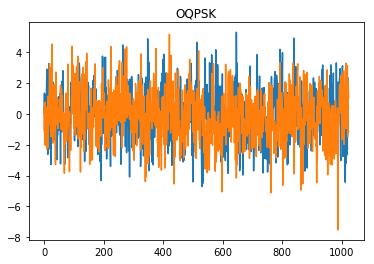

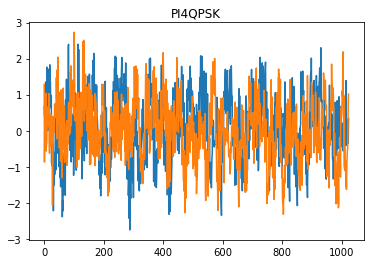

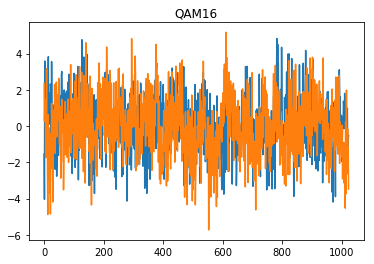

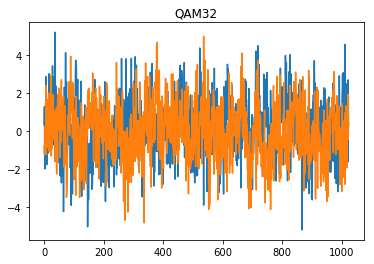

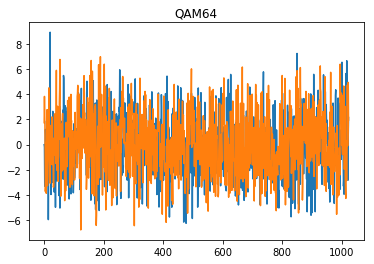

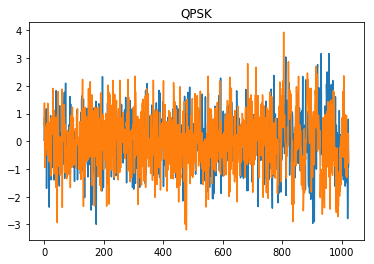

In [9]:
# for each modulation type, inspect some instances of data
for modType in data[0].modTypes[:]:
    min_SNR = -10
    max_SNR = 10
    snr_step = 4

    # get random snr within valid range
    snrValue = random.randrange(min_SNR, max_SNR, snr_step)

    # get a collection of signals
    collection_of_instances = data[0].dataCube[modType, snrValue]

    # get the complex samples for a specific instance within the collection
    cdata, index = get_complex_samples_for_instance(collection_of_instances)

    # setup inspect
    sample_rate = number_of_samples_in_instance
    Ts = 1.0 / sample_rate
    t = np.arange(0, len(cdata[0])) * Ts
    
    plt.figure()
    plt.title(modType)
    plt.plot(cdata.squeeze().real)
    plt.plot(cdata.squeeze().imag)
    # inspect signal
plt.show()    #data.inspect_signal(index, modType, snrValue, cdata[0], t.tolist(), number_of_samples_in_instance, sample_rate, 0, True)

In [12]:
def inception(input_img, fs=[64,64,64,64,64],height = 2, widths = [9,4],  with_residual=False):
    tower_1 = Conv2D(filters=fs[0], kernel_size=[height, 1], padding='same',activation='relu')(input_img)
    tower_2 = Conv2D(filters=fs[2], kernel_size=[height, 1], padding='same',activation='relu')(input_img)
    tower_2 = Conv2D(filters=fs[3], kernel_size=[height, widths[0]], padding='same',activation='relu')(tower_2)
    tower_3 = Conv2D(filters=fs[2], kernel_size=[height, 1], padding='same',activation='relu')(input_img)
    tower_3 = Conv2D(filters=fs[3], kernel_size=[height, widths[1]], padding='same',activation='relu')(tower_3)
    tower_4 = MaxPooling2D(3, strides=1, padding='same')(input_img)
    tower_4 = Conv2D(filters=fs[4], kernel_size=1, padding='same',activation='relu')(tower_4)
    
    if len(widths) == 3:
        tower_5 = Conv2D(filters=fs[2], kernel_size=[height, 1], padding='same',activation='relu')(input_img)
        tower_5 = Conv2D(filters=fs[3], kernel_size=[height, widths[2]], padding='same',activation='relu')(tower_5)
        output = keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4, tower_5], axis = 3)
    else:
        output = keras.layers.concatenate([tower_1, tower_2, tower_3, tower_4], axis = 3)
    if with_residual and output.shape==input_img.shape:
        output = output+input_img
    return output

def out_tower(x, dr=0.5):
    x = Dropout(dr)(x)
    output = Flatten()(x)
    logits = Dense(num_classes)(output)
    out = Activation('softmax')(logits)
    return out



def googleNet(x, data_format='channels_last', num_classes=24, num_layers = [1,1,1,1],features=[1,1,1,1,1]):
    x = Reshape(in_shp + (1,), input_shape=in_shp)(x)
    x = Conv2D(filters = 64*features[0], kernel_size=[2,7], strides=[1,2], data_format=data_format, padding='same', activation='relu')(x)
    x = MaxPooling2D([1, 3], strides=[1,2], padding='same')(x)
    for dep in range(num_layers[0]):
        x = Conv2D(filters = 192*features[1], kernel_size=[1, 3], strides=[1,1], padding='same', activation='relu')(x)
    x = MaxPooling2D([1,3], strides=[1,2], padding='same')(x)
    for dep in range(num_layers[1]):
        x = inception(x, widths=[9,4,12], fs=[128,32,32,32,32]*features[2])
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    for dep in range(num_layers[2]):
        x = inception(x, widths=[9,4], fs=[48,96,48,96,96]*features[3], with_residual=True)
    x = MaxPooling2D(3, strides=2, padding='same')(x)
    for dep in range(num_layers[3]):
        x = inception(x,height = 1, fs=[64,32,32,32,32]*features[4])
        
    out = out_tower(x, dr=0.5)
    return out

in_shp = (2, 1024)
input_img = Input(shape=in_shp)

# for our final model we used num_layers = [1,2,6,2]
out = googleNet(input_img,data_format='channels_last', num_classes=mods.size, num_layers = [1,1,1,1])
model = Model(inputs=input_img, outputs=out)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 2, 1024)      0                                            
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 2, 1024, 1)   0           input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_23 (Conv2D)              (None, 2, 512, 64)   960         reshape_2[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_8 (MaxPooling2D)  (None, 2, 256, 64)   0           conv2d_23[0][0]                  
__________________________________________________________________________________________________
conv2d_24 

In [13]:
# in_shp = (2, 1024)
# input_img = Input(shape=in_shp)
# x = Reshape(in_shp , input_shape=in_shp)(input_img)
# # x = Conv2D(filters=32, kernel_size=(1,5), padding='same', activation='relu')(x)
# # x = MaxPooling2D(pool_size=[2,2])(x)
# x = LSTM(64, return_sequences=True, input_shape=(2,1024))(x)
# # x = LSTM(64)(x)
# x = Dense(5, activation='softmax')(x)
# model = Model(inputs=input_img, outputs=x)
# model.summary()

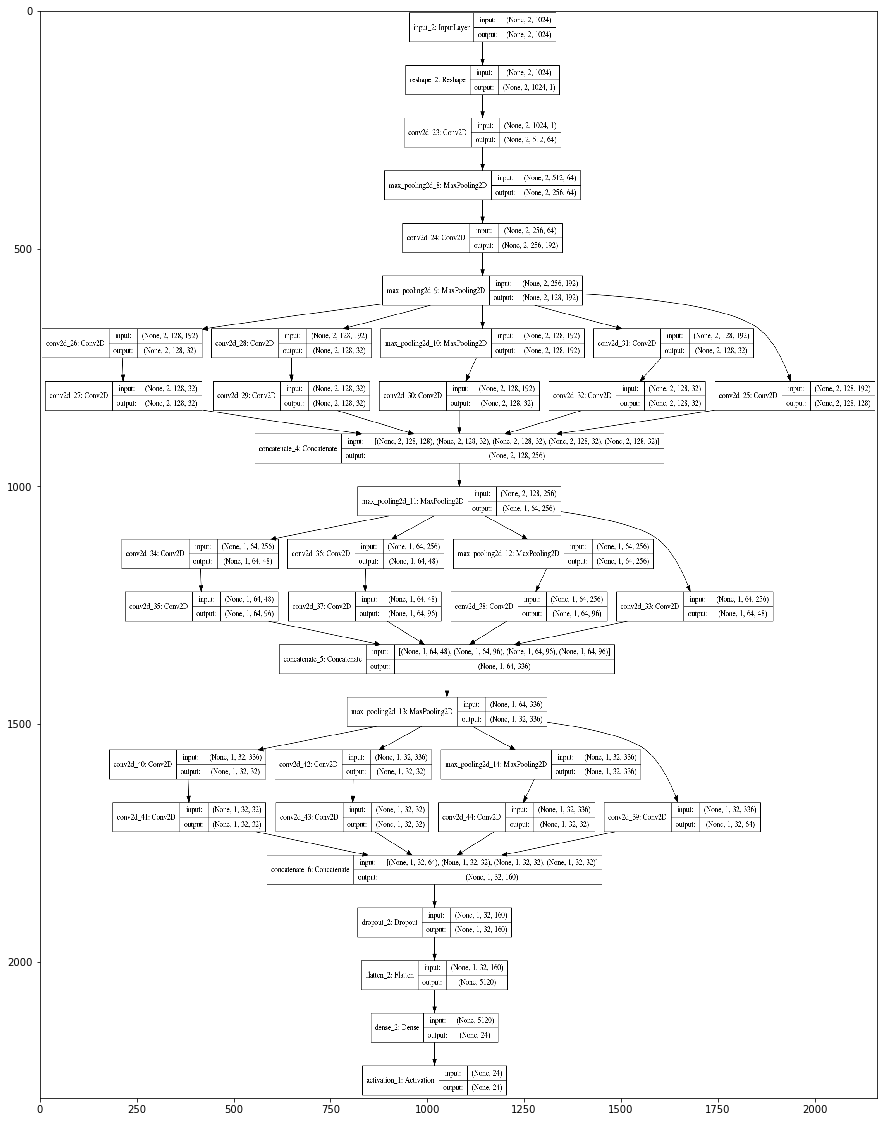

In [14]:
# Uncomment to visualize architecture
plot_model(model, to_file='model.png', show_shapes = True)

figure(figsize = (15,20))
img = mpimg.imread('model.png')
plt.imshow(img, aspect='auto')
plt.show()

In [15]:
# We trained till completion
train_batch_size, number_of_epochs = 512, 1        

val_batches = testdata.batch_iter(testdata.train_idx, train_batch_size, number_of_epochs, use_shuffle=False)
vsteps = testdata.train_idx.size//train_batch_size


generators = []
tsteps = 0
for d in data:
    generators.append(d.batch_iter(d.train_idx, train_batch_size, number_of_epochs, use_shuffle=False))
    tsteps += d.train_idx.size

tsteps = tsteps//train_batch_size 

from utils import perturb_batch

def train_batches(noise=None):
    while True:
        batches_x, batches_y = [], []

        for gen in generators:
            batch_x, batch_y = next(gen)
            batches_x.append(batch_x)
            batches_y.append(batch_y)
            
        batches_x = np.concatenate(batches_x)
        batches_y = np.concatenate(batches_y)
        
        ##### perturb
        batches_x = perturb_batch(batches_x, batches_y)    
        #####
        
        
        if noise:
            x,y,z = batches_x.shape
            batches_x += noise * np.random.randn(x, y, z)
        idx = np.random.permutation(batches_x.shape[0])
        
        batches_x = batches_x[idx]
        batches_y = batches_y[idx]
        
        for i in range(len(generators)):
            beg = i * train_batch_size
            end = beg + train_batch_size
            yield batches_x[beg:end], batches_y[beg:end]
        

train_batches = train_batches(noise=0.25)

In [19]:
# model = multi_gpu_model(model, gpus=2)
model.compile(loss='categorical_crossentropy', optimizer='adam')
filepath = '/tmp/morads/convmodrecnets_CNN2_0.5.wts.h5'


try:
    history = model.fit_generator(train_batches,
        nb_epoch=number_of_epochs,
        steps_per_epoch=tsteps,
        verbose=1,
        validation_data=val_batches,
        validation_steps=vsteps,
         callbacks = [
              keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss'    , verbose=0, save_best_only=True, mode='auto'),
              keras.callbacks.EarlyStopping(monitor='val_loss', patience=5    , verbose=0, mode='auto')
         ]) 
except(StopIteration):
    pass
    
model.save('mod_classifier21.h5')  

print("Done")

/home/morads/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  from ipykernel import kernelapp as app
/home/morads/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:15: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=1125, verbose=1, validation_data=<generator..., validation_steps=562, callbacks=[<keras.ca..., epochs=1)`
  from ipykernel import kernelapp as app


Epoch 1/1
Done


In [21]:
# Plot confusion matrix

model = load_model('../../mod_group0_val_loss0546.h5')
acc = {}
snrs = np.arange(-15,15, 5)

classes = testdata.modTypes

print("classes ", classes)
for snr in testdata.snrValues:

    # extract classes @ SNR
    snrThreshold_lower = snr
    snrThreshold_upper = snr+5
    snr_bounded_test_indicies = testdata.get_indicies_withSNRthrehsold(testdata.train_idx, snrThreshold_lower, snrThreshold_upper)
    
    test_X_i = testdata.signalData[snr_bounded_test_indicies]
    test_Y_i = testdata.oneHotLabels[snr_bounded_test_indicies] 

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    plt.figure(figsize=(10,10))
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("SNR", snr, "Overall Accuracy: ", cor / (cor+ncor), "Out of", len(snr_bounded_test_indicies))
    acc[snr] = 1.0*cor/(cor+ncor)

classes  ['16PSK', '2FSK_5KHz', '2FSK_75KHz', '8PSK', 'AM_DSB', 'AM_SSB', 'APSK16_c34', 'APSK32_c34', 'BPSK', 'CPFSK_5KHz', 'CPFSK_75KHz', 'FM_NB', 'FM_WB', 'GFSK_5KHz', 'GFSK_75KHz', 'GMSK', 'MSK', 'NOISE', 'OQPSK', 'PI4QPSK', 'QAM16', 'QAM32', 'QAM64', 'QPSK']
SNR -10 Overall Accuracy:  0.5518020833333334 Out of 96000
SNR -6 Overall Accuracy:  0.7723541666666667 Out of 96000
SNR -2 Overall Accuracy:  0.8928020833333333 Out of 96000
SNR 2 Overall Accuracy:  0.92640625 Out of 96000
SNR 6 Overall Accuracy:  0.9354166666666667 Out of 96000
SNR 10 Overall Accuracy:  0.936375 Out of 48000


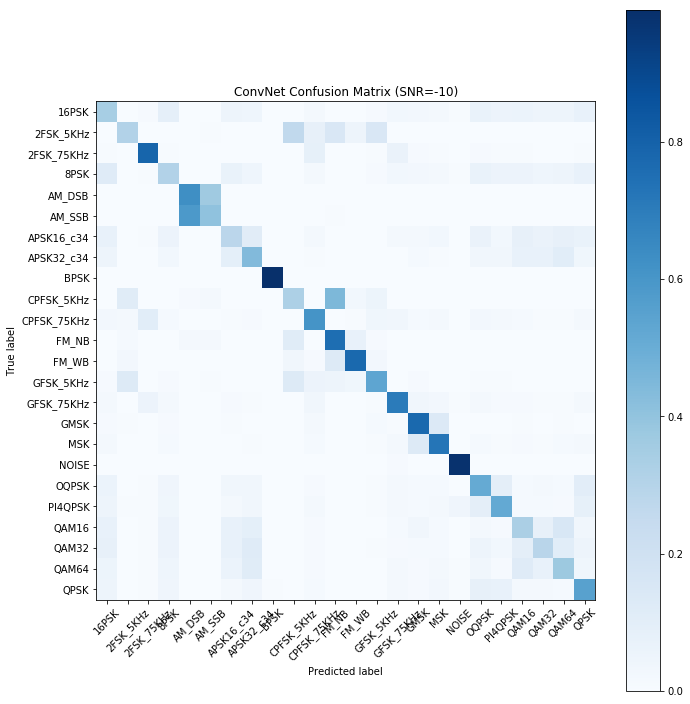

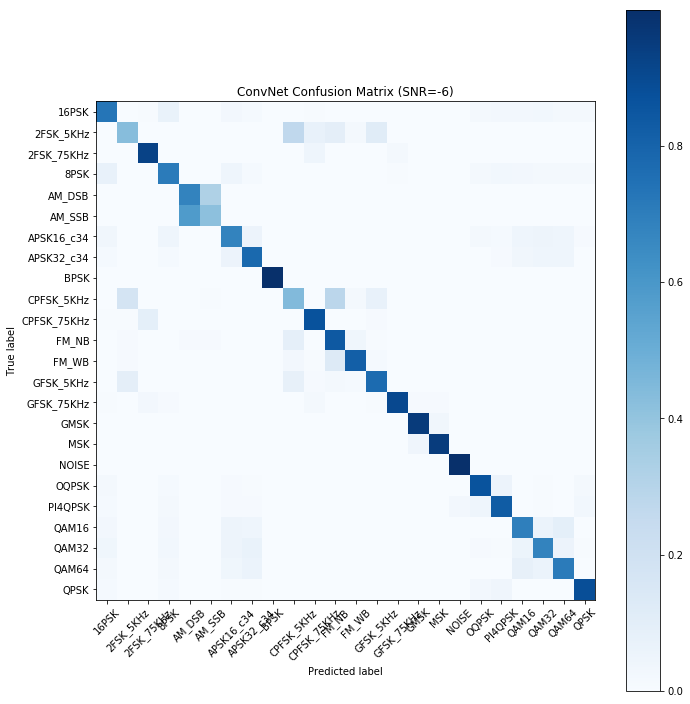

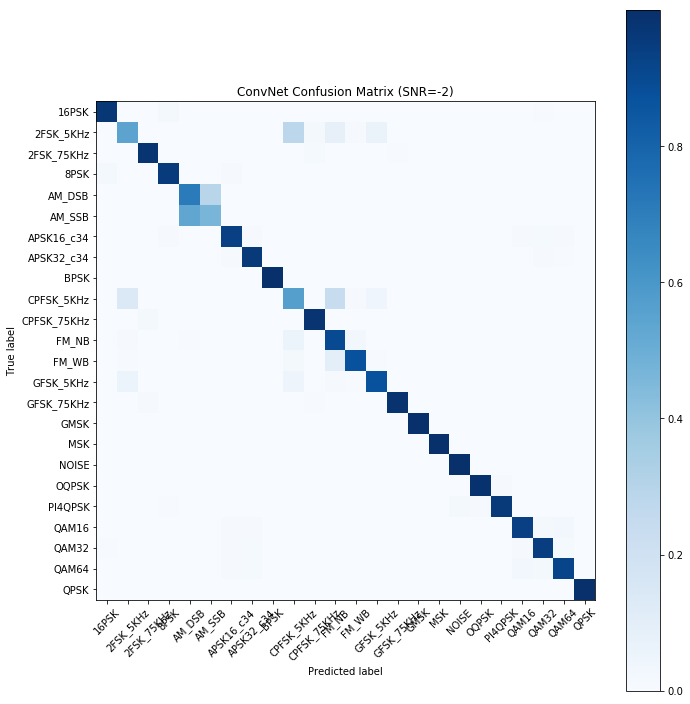

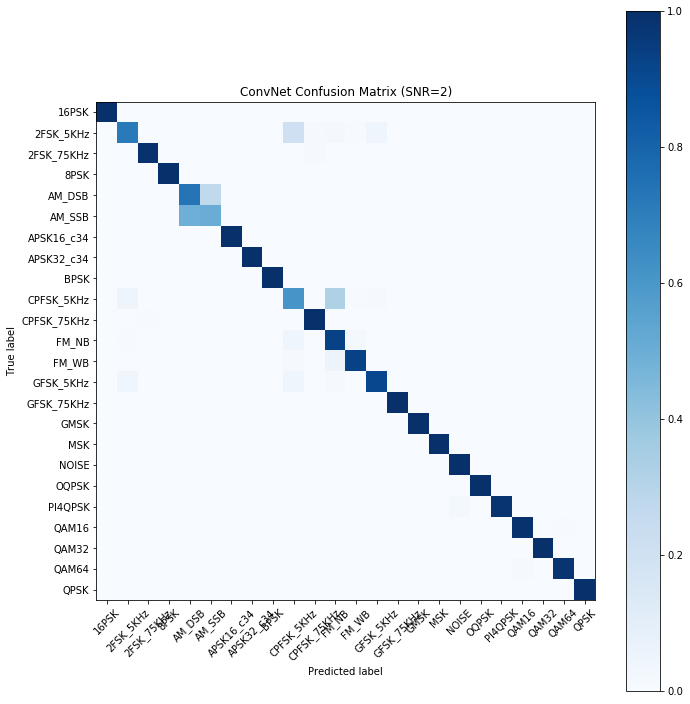

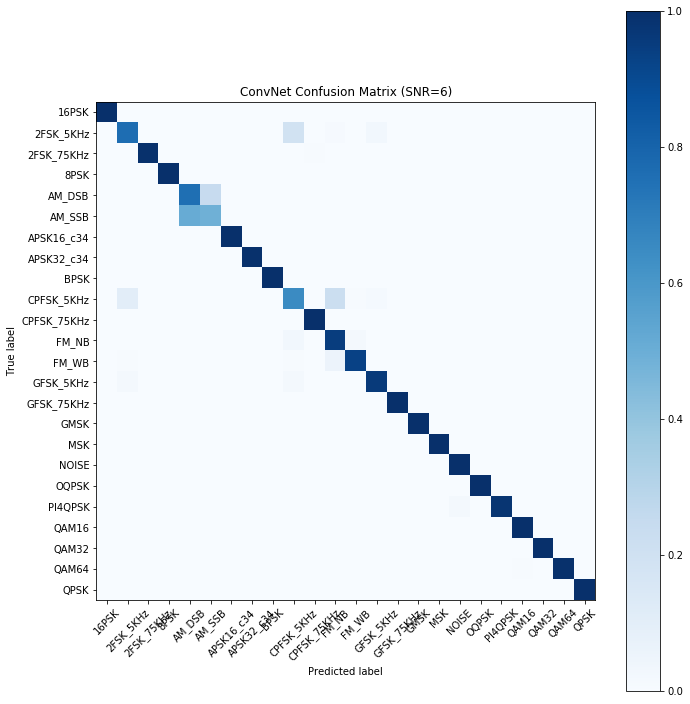

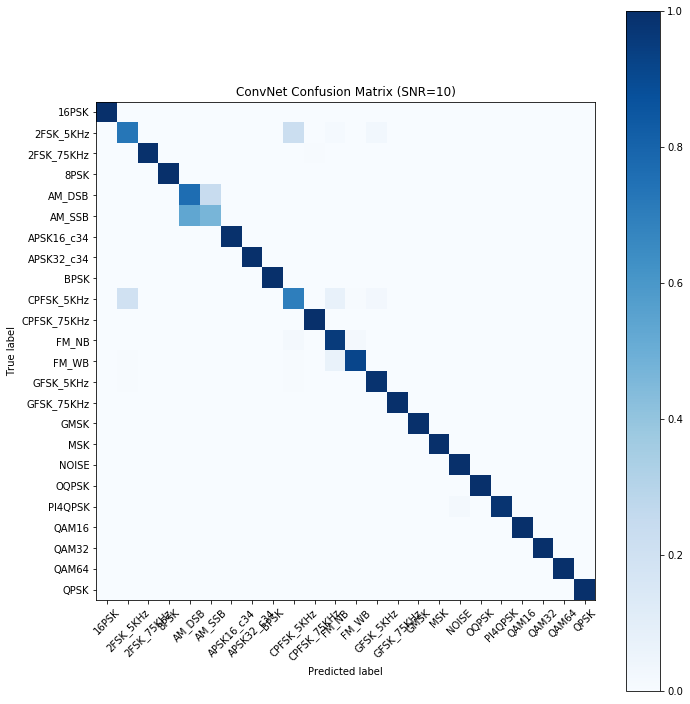

In [22]:
plt.show()